<a href="https://colab.research.google.com/github/abhi99-ut/aih/blob/feature%2Fdl_ml_hw/AIH_ML_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set Up

In [ ]:

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [ ]:
# Set your project ID here
project_id = "abhishek-project-001"
client = bigquery.Client(project=project_id)

### Data Prep

In [ ]:
query = """
WITH admission_details AS (
    -- Step 1: Extract admission details
    SELECT
        SUBJECT_ID,
        HADM_ID,
        ADMITTIME,
        DISCHTIME,
        ADMISSION_TYPE,
        ADMISSION_LOCATION,
        INSURANCE,
        LANGUAGE,
        RELIGION,
        MARITAL_STATUS,
        ETHNICITY
    FROM
        `physionet-data.mimiciii_clinical.admissions`
),

icu_transfers AS (
    -- Step 2: Identify ICU transfers and calculate hours to ICU
    SELECT
        icu.SUBJECT_ID,
        icu.HADM_ID,
        icu.ICUSTAY_ID,
        icu.INTIME AS ICU_ADMITTIME,
        icu.OUTTIME AS ICU_DISCHTIME,
        TIMESTAMP_DIFF(icu.INTIME, adm.ADMITTIME, HOUR) AS HOURS_TO_ICU
    FROM
        `physionet-data.mimiciii_clinical.icustays` icu
    JOIN
        admission_details adm
    ON
        icu.SUBJECT_ID = adm.SUBJECT_ID
        AND icu.HADM_ID = adm.HADM_ID
),

diagnosis_history AS (
    -- Step 3: Aggregate diagnosis codes for each patient admission
    SELECT
        SUBJECT_ID,
        HADM_ID,
        STRING_AGG(DISTINCT ICD9_CODE) AS DIAGNOSIS_CODES
    FROM
        `physionet-data.mimiciii_clinical.diagnoses_icd`
    GROUP BY
        SUBJECT_ID, HADM_ID
),

procedure_history AS (
    -- Step 4: Aggregate procedure codes for each patient admission
    SELECT
        SUBJECT_ID,
        HADM_ID,
        STRING_AGG(DISTINCT ICD9_CODE) AS PROCEDURE_CODES
    FROM
        `physionet-data.mimiciii_clinical.procedures_icd`
    GROUP BY
        SUBJECT_ID, HADM_ID
),

vitals_summary AS (
    -- Step 5: Summarize vital signs (mean, min, max) within the first 6 hours of admission
    SELECT
        ce.SUBJECT_ID,
        ce.HADM_ID,
        AVG(ce.VALUENUM) AS AVG_VITAL,
        MIN(ce.VALUENUM) AS MIN_VITAL,
        MAX(ce.VALUENUM) AS MAX_VITAL
    FROM
        `physionet-data.mimiciii_clinical.chartevents` ce
    JOIN
        admission_details adm
    ON
        ce.SUBJECT_ID = adm.SUBJECT_ID
        AND ce.HADM_ID = adm.HADM_ID
    WHERE
        ce.ITEMID IN (211, 220045, 618, 220210, 51, 442, 455, 220179, 8368, 8441, 220180, 52, 456, 220181, 676, 678, 223761, 646, 220277, 807, 1529, 3745, 220621, 226537)
        AND ce.CHARTTIME BETWEEN adm.ADMITTIME AND TIMESTAMP_ADD(adm.ADMITTIME, INTERVAL 6 HOUR)
    GROUP BY
        ce.SUBJECT_ID, ce.HADM_ID
)
SELECT
    adm.SUBJECT_ID,
    adm.HADM_ID,
    adm.ADMITTIME,
    adm.DISCHTIME,
    adm.ADMISSION_TYPE,
    adm.ADMISSION_LOCATION,
    adm.INSURANCE,
    adm.LANGUAGE,
    adm.RELIGION,
    adm.MARITAL_STATUS,
    adm.ETHNICITY,
    icu.ICU_ADMITTIME,
    icu.ICU_DISCHTIME,
    icu.HOURS_TO_ICU,
    CASE
        WHEN icu.HOURS_TO_ICU <= 24 THEN 1
        ELSE 0
    END AS ICU_ADMISSION_RISK,
    diag.DIAGNOSIS_CODES,
    proc.PROCEDURE_CODES,
    vitals.AVG_VITAL,
    vitals.MIN_VITAL,
    vitals.MAX_VITAL
FROM
    admission_details adm
LEFT JOIN
    icu_transfers icu
ON
    adm.SUBJECT_ID = icu.SUBJECT_ID
    AND adm.HADM_ID = icu.HADM_ID
LEFT JOIN
    diagnosis_history diag
ON
    adm.SUBJECT_ID = diag.SUBJECT_ID
    AND adm.HADM_ID = diag.HADM_ID
LEFT JOIN
    procedure_history proc
ON
    adm.SUBJECT_ID = proc.SUBJECT_ID
    AND adm.HADM_ID = proc.HADM_ID
LEFT JOIN
    vitals_summary vitals
ON
    adm.SUBJECT_ID = vitals.SUBJECT_ID
    AND adm.HADM_ID = vitals.HADM_ID;



"""

In [ ]:
df = client.query(query).to_dataframe()

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICU_ADMITTIME,ICU_DISCHTIME,HOURS_TO_ICU,ICU_ADMISSION_RISK,DIAGNOSIS_CODES,PROCEDURE_CODES,AVG_VITAL,MIN_VITAL,MAX_VITAL
0,3115,134067,2139-02-13 03:11:00,2139-02-20 07:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2139-02-13 03:12:00,2139-02-18 13:42:00,0,1,"8601,E966,30500,V600","9604,9672,3404,9462",81.871114,12.0,126.0
1,7124,109129,2188-07-11 00:58:00,2188-08-01 12:04:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2188-07-11 00:59:00,2188-07-24 12:03:00,0,1,"0389,5070,51884,99676,7070,5997,3330,25000,4589","9672,9604,966,8628,3893",70.997059,18.0,108.0
2,10348,121510,2133-04-16 21:12:00,2133-04-23 15:52:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,UNKNOWN/NOT SPECIFIED,2133-04-16 21:13:00,2133-04-18 15:06:00,0,1,"3453,496,3483,3310,29410,4019,25000,920,E8889","9671,3891,0331",101.281955,0.0,261.0
3,9396,106469,2109-02-16 23:14:00,2109-02-23 12:01:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2109-02-16 23:15:00,2109-02-19 16:10:00,0,1,"85221,9210,E8889,2948,4019,7310,6000",0131,85.850451,15.0,151.0
4,9333,133732,2167-10-06 18:35:00,2167-10-16 13:13:00,URGENT,TRANSFER FROM HOSP/EXTRAM,Private,None,None,None,UNKNOWN/NOT SPECIFIED,2167-10-08 07:38:00,2167-10-13 12:55:00,37,0,"41071,41401,25000,2720","3612,3961",NaN,NaN,NaN


### EDA

In [ ]:
df.shape

(62722, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62722 entries, 0 to 62721
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          62722 non-null  Int64         
 1   HADM_ID             62722 non-null  Int64         
 2   ADMITTIME           62722 non-null  datetime64[us]
 3   DISCHTIME           62722 non-null  datetime64[us]
 4   ADMISSION_TYPE      62722 non-null  object        
 5   ADMISSION_LOCATION  62722 non-null  object        
 6   INSURANCE           62722 non-null  object        
 7   LANGUAGE            36032 non-null  object        
 8   RELIGION            62240 non-null  object        
 9   MARITAL_STATUS      52344 non-null  object        
 10  ETHNICITY           62722 non-null  object        
 11  ICU_ADMITTIME       61532 non-null  datetime64[us]
 12  ICU_DISCHTIME       61522 non-null  datetime64[us]
 13  HOURS_TO_ICU        61532 non-null  Int64     

#### Data describe

In [ ]:
df.describe()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ICU_ADMITTIME,ICU_DISCHTIME,HOURS_TO_ICU,ICU_ADMISSION_RISK,AVG_VITAL,MIN_VITAL,MAX_VITAL
count,62722.0,62722.0,62722,62722,61532,61522,61532.0,62722.0,42522.000000,42522.000000,4.252200e+04
mean,33839.235771,149952.404643,2151-03-22 04:49:42.453046,2151-04-02 09:47:48.125697,2151-03-20 13:56:55.438064,2151-03-26 06:26:52.360473,42.191429,0.758458,92.451259,33.941729,2.289151e+02
min,2.0,100001.0,2100-06-07 19:59:00,2100-06-09 17:09:00,2100-06-07 20:00:22,2100-06-08 14:59:31,-36.0,0.0,25.722222,0.000000,2.800000e+01
25%,12022.25,124919.0,2126-03-02 04:29:15,2126-03-15 18:33:45,2126-03-01 09:44:44,2126-03-04 23:55:48,0.0,1.0,75.004236,12.000000,1.320000e+02
50%,24237.5,149936.5,2151-01-08 17:59:00,2151-01-25 03:50:00,2151-01-07 22:00:42.500000,2151-01-15 01:11:18,0.0,1.0,81.544281,16.000000,1.500000e+02
75%,54095.75,174974.75,2176-07-08 19:33:45,2176-07-17 13:22:30,2176-07-07 22:16:04.500000,2176-07-11 19:28:33.750000,19.0,1.0,93.159320,22.000000,1.720000e+02
max,99999.0,199999.0,2210-08-17 17:13:00,2210-08-24 19:43:00,2210-08-18 12:34:24,2210-08-20 18:35:13,4816.0,1.0,56159.709524,452.000000,2.355555e+06
std,28110.929504,28898.96815,NaN,NaN,NaN,NaN,143.360783,0.428022,274.650533,43.382254,1.146766e+04


In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum()/df.shape[0]*100)

# Check data types
print("\nData Types:")
print(df.dtypes)



Missing Values:
SUBJECT_ID             0.000000
HADM_ID                0.000000
ADMITTIME              0.000000
DISCHTIME              0.000000
ADMISSION_TYPE         0.000000
ADMISSION_LOCATION     0.000000
INSURANCE              0.000000
LANGUAGE              42.552852
RELIGION               0.768470
MARITAL_STATUS        16.546029
ETHNICITY              0.000000
ICU_ADMITTIME          1.897261
ICU_DISCHTIME          1.913204
HOURS_TO_ICU           1.897261
ICU_ADMISSION_RISK     0.000000
DIAGNOSIS_CODES        0.074934
PROCEDURE_CODES       10.843085
AVG_VITAL             32.205606
MIN_VITAL             32.205606
MAX_VITAL             32.205606
dtype: float64

Data Types:
SUBJECT_ID                     Int64
HADM_ID                        Int64
ADMITTIME             datetime64[us]
DISCHTIME             datetime64[us]
ADMISSION_TYPE                object
ADMISSION_LOCATION            object
INSURANCE                     object
LANGUAGE                      object
RELIGION           

#### Y variable distribution

In [ ]:
df.groupby(['ICU_ADMISSION_RISK'])['ICU_ADMISSION_RISK'].count()

,ICU_ADMISSION_RISK
ICU_ADMISSION_RISK,
0,15150
1,47572


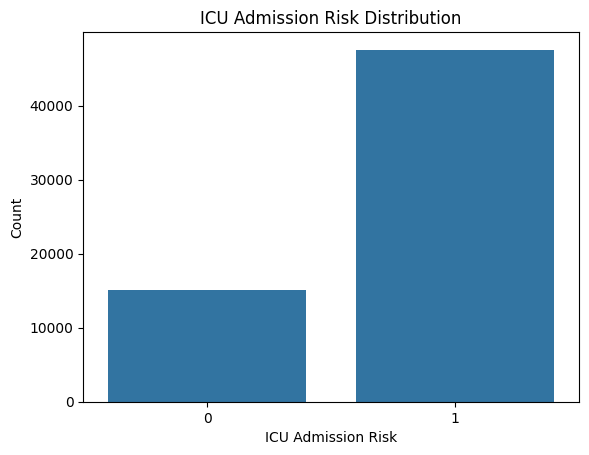

In [ ]:
sns.countplot(data=df, x='ICU_ADMISSION_RISK')
plt.title('ICU Admission Risk Distribution')
plt.xlabel('ICU Admission Risk')
plt.ylabel('Count')
plt.show()

#### Admission type - ICU Risk

In [ ]:
df.groupby(['ICU_ADMISSION_RISK','ADMISSION_TYPE',])['ADMISSION_TYPE'].count()

ICU_ADMISSION_RISK  ADMISSION_TYPE
0                   ELECTIVE           2715
                    EMERGENCY         11178
                    NEWBORN             726
                    URGENT              531
1                   ELECTIVE           5391
                    EMERGENCY         34021
                    NEWBORN            7245
                    URGENT              915
Name: ADMISSION_TYPE, dtype: int64

#### Hours to ICU

<Axes: >

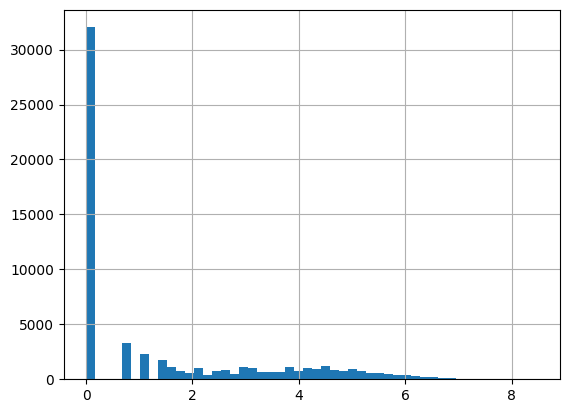

In [ ]:
np.log(df['HOURS_TO_ICU'].clip(lower=0) + 1).hist(bins=50)

#### Hours to ICU by Admission type

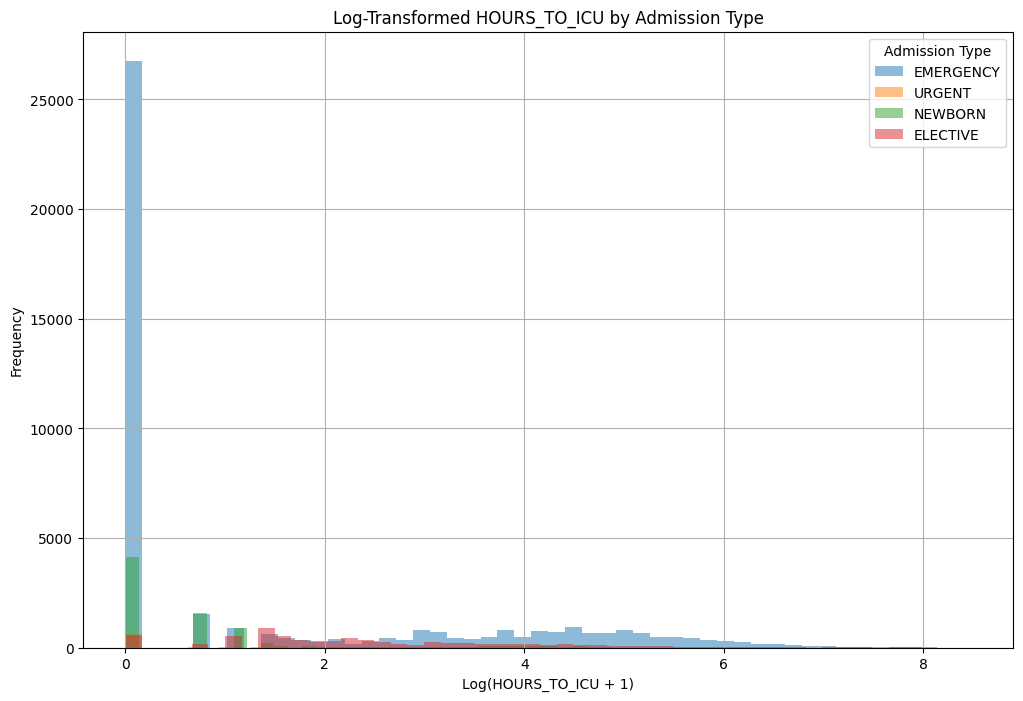

In [ ]:
# Ensure HOURS_TO_ICU is non-negative
df['HOURS_TO_ICU'] = df['HOURS_TO_ICU'].clip(lower=0)

# Log-transform HOURS_TO_ICU
df['LOG_HOURS_TO_ICU'] = np.log(df['HOURS_TO_ICU'] + 1)

# Group by ADMISSION_TYPE and plot histograms
admission_types = df['ADMISSION_TYPE'].unique()

plt.figure(figsize=(12, 8))
for admission_type in admission_types:
    subset = df[df['ADMISSION_TYPE'] == admission_type]
    subset['LOG_HOURS_TO_ICU'].hist(bins=50, alpha=0.5, label=admission_type)

plt.title('Log-Transformed HOURS_TO_ICU by Admission Type')
plt.xlabel('Log(HOURS_TO_ICU + 1)')
plt.ylabel('Frequency')
plt.legend(title='Admission Type')
plt.show()


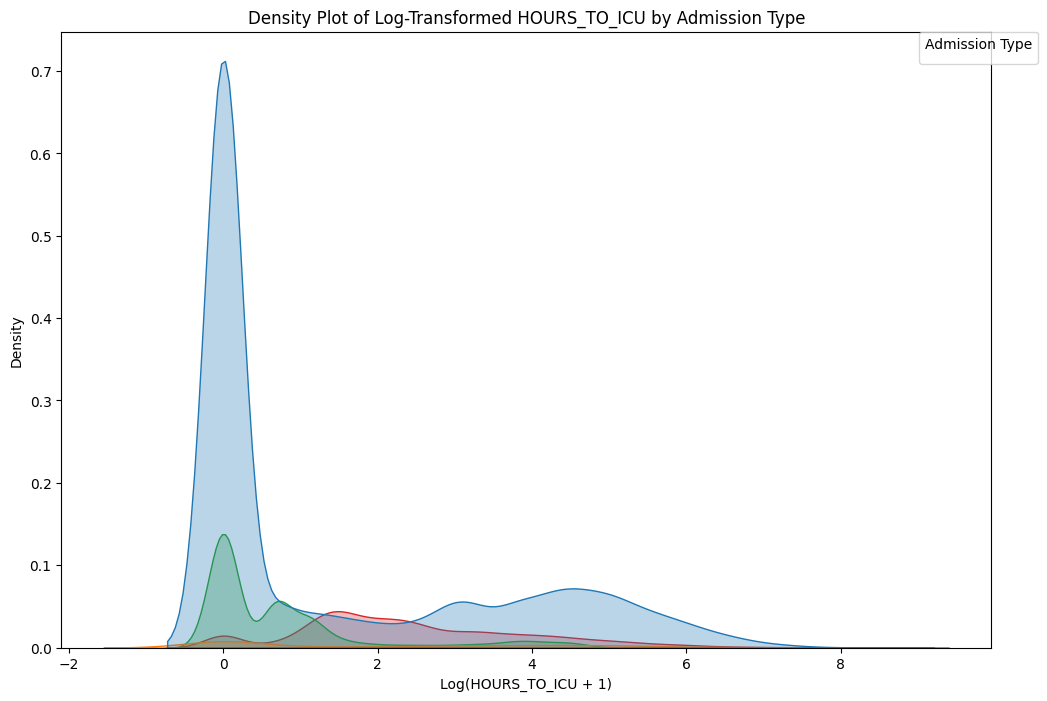

In [ ]:
# Ensure HOURS_TO_ICU is non-negative
df['HOURS_TO_ICU'] = df['HOURS_TO_ICU'].clip(lower=0)

# Log-transform HOURS_TO_ICU
df['LOG_HOURS_TO_ICU'] = np.log(df['HOURS_TO_ICU'] + 1)

# Plot density plots grouped by ADMISSION_TYPE
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='LOG_HOURS_TO_ICU', hue='ADMISSION_TYPE', fill=True, alpha=0.3)

# Ensure legend is displayed
plt.legend(title='Admission Type', loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title('Density Plot of Log-Transformed HOURS_TO_ICU by Admission Type')
plt.xlabel('Log(HOURS_TO_ICU + 1)')
plt.ylabel('Density')
plt.show()


#### Admission Type Distribution


Admission Type Counts:
ADMISSION_TYPE
EMERGENCY    45199
ELECTIVE      8106
NEWBORN       7971
URGENT        1446
Name: count, dtype: int64


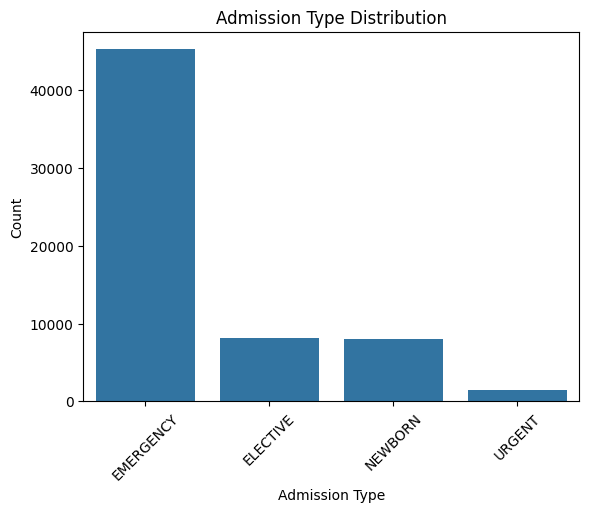

In [ ]:
# Admission Type Analysis
admission_counts = df['ADMISSION_TYPE'].value_counts()
print("\nAdmission Type Counts:")
print(admission_counts)

# Visualize Admission Type
sns.countplot(data=df, x='ADMISSION_TYPE', order=admission_counts.index)
plt.title('Admission Type Distribution')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


####  Ethnicity Distribution


Ethnicity Distribution:
ETHNICITY
WHITE                             43692
BLACK/AFRICAN AMERICAN             5759
UNKNOWN/NOT SPECIFIED              4826
HISPANIC OR LATINO                 1780
OTHER                              1592
ASIAN                              1568
UNABLE TO OBTAIN                    883
PATIENT DECLINED TO ANSWER          582
ASIAN - CHINESE                     290
HISPANIC/LATINO - PUERTO RICAN      243
Name: count, dtype: int64


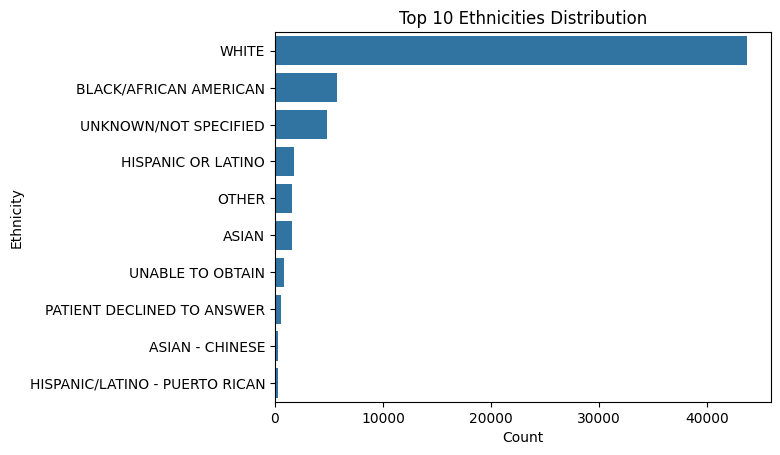

In [ ]:
# Ethnicity Distribution
ethnicity_counts = df['ETHNICITY'].value_counts()
print("\nEthnicity Distribution:")
print(ethnicity_counts.head(10))  # Display top 10

# Visualize Ethnicity
sns.barplot(y=ethnicity_counts.index[:10], x=ethnicity_counts.values[:10])
plt.title('Top 10 Ethnicities Distribution')
plt.xlabel('Count')
plt.ylabel('Ethnicity')
plt.show()


#### common diagnoses

In [ ]:
# Check common diagnoses
df['DIAGNOSIS_CODES'] = df['DIAGNOSIS_CODES'].fillna('')
diagnosis_counts = df['DIAGNOSIS_CODES'].str.split(',').explode().value_counts()
print("\nTop Diagnoses:")
print(diagnosis_counts.head(10))

# Check common procedures
df['PROCEDURE_CODES'] = df['PROCEDURE_CODES'].fillna('')
procedure_counts = df['PROCEDURE_CODES'].str.split(',').explode().value_counts()
print("\nTop Procedures:")
print(procedure_counts.head(10))



Top Diagnoses:
DIAGNOSIS_CODES
4019     21950
4280     14386
42731    14186
41401    13232
5849     10146
25000     9697
2724      9220
51881     8616
5990      7420
53081     6664
Name: count, dtype: int64

Top Procedures:
PROCEDURE_CODES
3893    14906
9604    11108
966     10559
9671     9645
9904     8114
3961     7325
9672     6913
         6801
9955     5901
8856     5534
Name: count, dtype: int64


#### Vitals Summary

In [ ]:
vital_columns = ['AVG_VITAL', 'MIN_VITAL', 'MAX_VITAL']
print("\nVital Signs Summary:")
print(df[vital_columns].describe())




Vital Signs Summary:
          AVG_VITAL     MIN_VITAL     MAX_VITAL
count  42522.000000  42522.000000  4.252200e+04
mean      92.451259     33.941729  2.289151e+02
std      274.650533     43.382254  1.146766e+04
min       25.722222      0.000000  2.800000e+01
25%       75.004236     12.000000  1.320000e+02
50%       81.544281     16.000000  1.500000e+02
75%       93.159320     22.000000  1.720000e+02
max    56159.709524    452.000000  2.355555e+06


#### ICU Admission Risk by Admission type

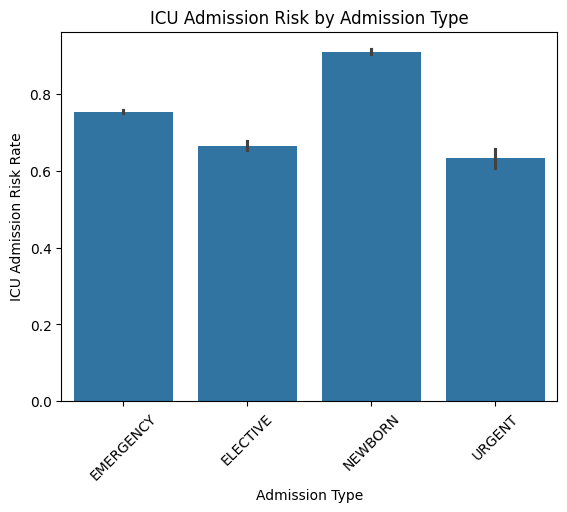

In [ ]:
# Plot ICU Admission Risk by Admission Type
sns.barplot(
    data=df, x='ADMISSION_TYPE', y='ICU_ADMISSION_RISK',
    order=df['ADMISSION_TYPE'].value_counts().index
)
plt.title('ICU Admission Risk by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('ICU Admission Risk Rate')
plt.xticks(rotation=45)
plt.show()


#### ICU Admission Risk by Ethnicity (Top 10 Ethnicities)

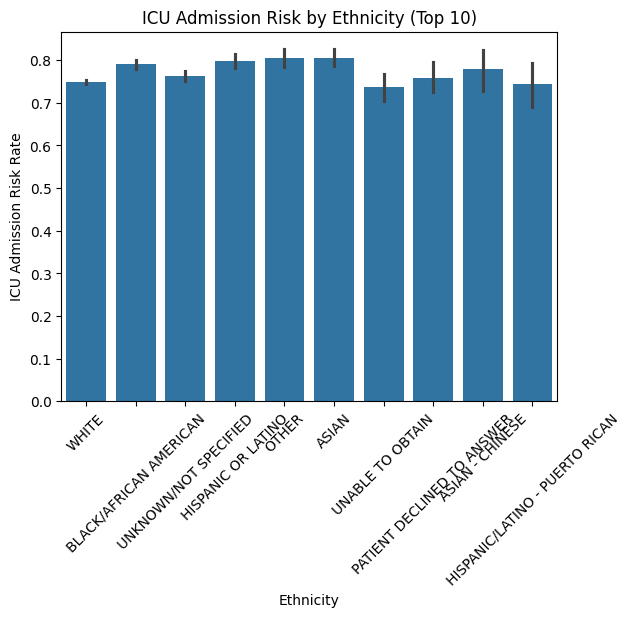

In [ ]:
# Plot ICU Admission Risk by Ethnicity (Top 10 Ethnicities)
top_ethnicities = ethnicity_counts.index[:10]
ethnicity_df = df[df['ETHNICITY'].isin(top_ethnicities)]
sns.barplot(
    data=ethnicity_df, x='ETHNICITY', y='ICU_ADMISSION_RISK',
    order=top_ethnicities
)
plt.title('ICU Admission Risk by Ethnicity (Top 10)')
plt.xlabel('Ethnicity')
plt.ylabel('ICU Admission Risk Rate')
plt.xticks(rotation=45)
plt.show()


In [ ]:
pd.options.display.max_columns = None

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICU_ADMITTIME,ICU_DISCHTIME,HOURS_TO_ICU,ICU_ADMISSION_RISK,DIAGNOSIS_CODES,PROCEDURE_CODES,AVG_VITAL,MIN_VITAL,MAX_VITAL,LOG_HOURS_TO_ICU
0,3115,134067,2139-02-13 03:11:00,2139-02-20 07:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2139-02-13 03:12:00,2139-02-18 13:42:00,0,1,"8601,E966,30500,V600","9604,9672,3404,9462",81.871114,12.0,126.0,0.0
1,7124,109129,2188-07-11 00:58:00,2188-08-01 12:04:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2188-07-11 00:59:00,2188-07-24 12:03:00,0,1,"0389,5070,51884,99676,7070,5997,3330,25000,4589","9672,9604,966,8628,3893",70.997059,18.0,108.0,0.0
2,10348,121510,2133-04-16 21:12:00,2133-04-23 15:52:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,UNKNOWN/NOT SPECIFIED,2133-04-16 21:13:00,2133-04-18 15:06:00,0,1,"3453,496,3483,3310,29410,4019,25000,920,E8889","9671,3891,0331",101.281955,0.0,261.0,0.0
3,9396,106469,2109-02-16 23:14:00,2109-02-23 12:01:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,None,None,WHITE,2109-02-16 23:15:00,2109-02-19 16:10:00,0,1,"85221,9210,E8889,2948,4019,7310,6000",0131,85.850451,15.0,151.0,0.0
4,9333,133732,2167-10-06 18:35:00,2167-10-16 13:13:00,URGENT,TRANSFER FROM HOSP/EXTRAM,Private,None,None,None,UNKNOWN/NOT SPECIFIED,2167-10-08 07:38:00,2167-10-13 12:55:00,37,0,"41071,41401,25000,2720","3612,3961",NaN,NaN,NaN,3.637586


### Data Cleaning - Feature engineering

In [ ]:
# Replace specific patterns in the ETHNICITY column using .replace without inplace
df['ETHNICITY'] = df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN')
df['ETHNICITY'] = df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE')
df['ETHNICITY'] = df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO')
df['ETHNICITY'] = df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN')
df['ETHNICITY'] = df['ETHNICITY'].replace(
    ['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN/NOT SPECIFIED'],
    value='OTHER/UNKNOWN'
)

# Handle less frequent ethnicities and group them under 'OTHER/UNKNOWN'
top_ethnicities = df['ETHNICITY'].value_counts().nlargest(5).index.tolist()
df.loc[~df['ETHNICITY'].isin(top_ethnicities), 'ETHNICITY'] = 'OTHER/UNKNOWN'


In [ ]:
df.loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE']), 'RELIGION'] = 'RELIGIOUS'


In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICU_ADMITTIME,ICU_DISCHTIME,HOURS_TO_ICU,ICU_ADMISSION_RISK,DIAGNOSIS_CODES,PROCEDURE_CODES,AVG_VITAL,MIN_VITAL,MAX_VITAL,LOG_HOURS_TO_ICU
0,3115,134067,2139-02-13 03:11:00,2139-02-20 07:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,RELIGIOUS,None,WHITE,2139-02-13 03:12:00,2139-02-18 13:42:00,0,1,"8601,E966,30500,V600","9604,9672,3404,9462",81.871114,12.0,126.0,0.0
1,7124,109129,2188-07-11 00:58:00,2188-08-01 12:04:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,RELIGIOUS,None,WHITE,2188-07-11 00:59:00,2188-07-24 12:03:00,0,1,"0389,5070,51884,99676,7070,5997,3330,25000,4589","9672,9604,966,8628,3893",70.997059,18.0,108.0,0.0
2,10348,121510,2133-04-16 21:12:00,2133-04-23 15:52:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,RELIGIOUS,None,OTHER/UNKNOWN,2133-04-16 21:13:00,2133-04-18 15:06:00,0,1,"3453,496,3483,3310,29410,4019,25000,920,E8889","9671,3891,0331",101.281955,0.0,261.0,0.0
3,9396,106469,2109-02-16 23:14:00,2109-02-23 12:01:00,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,None,RELIGIOUS,None,WHITE,2109-02-16 23:15:00,2109-02-19 16:10:00,0,1,"85221,9210,E8889,2948,4019,7310,6000",0131,85.850451,15.0,151.0,0.0
4,9333,133732,2167-10-06 18:35:00,2167-10-16 13:13:00,URGENT,TRANSFER FROM HOSP/EXTRAM,Private,None,RELIGIOUS,None,OTHER/UNKNOWN,2167-10-08 07:38:00,2167-10-13 12:55:00,37,0,"41071,41401,25000,2720","3612,3961",NaN,NaN,NaN,3.637586


In [ ]:
# Binary Encoding for Diagnosis and Procedure Codes
df['has_hypertension'] = df['DIAGNOSIS_CODES'].apply(lambda x: 1 if isinstance(x, str) and '401' in x else 0)
df['has_diabetes'] = df['DIAGNOSIS_CODES'].apply(lambda x: 1 if isinstance(x, str) and '250' in x else 0)
df['had_blood_transfusion'] = df['PROCEDURE_CODES'].apply(lambda x: 1 if isinstance(x, str) and '99' in x else 0)


### Modelling

In [ ]:
# Standardize vital signs
vital_columns = ['AVG_VITAL', 'MIN_VITAL', 'MAX_VITAL']
scaler = StandardScaler()
df[vital_columns] = scaler.fit_transform(df[vital_columns])

# Check distribution of target variable
print(df['ICU_ADMISSION_RISK'].value_counts())


ICU_ADMISSION_RISK
1    47572
0    15150
Name: count, dtype: Int64


In [ ]:
# Define features (X) and target (y)
X = df.drop(columns=['ICU_ADMISSION_RISK','ADMISSION_LOCATION', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DIAGNOSIS_CODES', 'PROCEDURE_CODES','LOG_HOURS_TO_ICU','ICU_ADMITTIME','ICU_DISCHTIME','HOURS_TO_ICU','HOURS_TO_ICU'])
y = df['ICU_ADMISSION_RISK']

In [ ]:
X

,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,AVG_VITAL,MIN_VITAL,MAX_VITAL,has_hypertension,has_diabetes,had_blood_transfusion
0,EMERGENCY,Medicare,None,RELIGIOUS,None,WHITE,-0.038523,-0.505783,-0.008974,0,0,0
1,EMERGENCY,Medicare,None,RELIGIOUS,None,WHITE,-0.078115,-0.367476,-0.010544,0,1,0
2,EMERGENCY,Medicare,None,RELIGIOUS,None,OTHER/UNKNOWN,0.032153,-0.782397,0.002798,1,1,0
3,EMERGENCY,Medicare,None,RELIGIOUS,None,WHITE,-0.024034,-0.436629,-0.006794,1,0,0
4,URGENT,Private,None,RELIGIOUS,None,OTHER/UNKNOWN,NaN,NaN,NaN,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62717,EMERGENCY,Medicare,None,RELIGIOUS,UNKNOWN (DEFAULT),WHITE,-0.089975,-0.482731,-0.010980,1,0,1
62718,EMERGENCY,Private,ENGL,RELIGIOUS,UNKNOWN (DEFAULT),OTHER/UNKNOWN,-0.067265,-0.505783,-0.006882,0,0,1
62719,EMERGENCY,Medicare,ENGL,RELIGIOUS,UNKNOWN (DEFAULT),WHITE,-0.059381,-0.482731,-0.011242,1,1,0
62720,EMERGENCY,Medicare,None,RELIGIOUS,UNKNOWN (DEFAULT),WHITE,-0.033593,0.254906,-0.010631,0,0,1


In [ ]:
X.columns

Index(['ADMISSION_TYPE', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'AVG_VITAL', 'MIN_VITAL', 'MAX_VITAL', 'has_hypertension',
       'has_diabetes', 'had_blood_transfusion'],
      dtype='object')

In [ ]:
categorical_cols = ['ADMISSION_TYPE', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']

X = pd.get_dummies(X, columns=categorical_cols, dummy_na=False, drop_first=False) #dummy_na=False to not create a new category for NaN values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XgboostModel
rf = XGBClassifier(random_state=42, n_estimators=100, max_depth=10,enable_categorical=True) # enable_categorical=True to explicitly enable categorical data handling
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))



Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.64      0.76      0.70      3030
         1.0       0.92      0.87      0.89      9515

    accuracy                           0.84     12545
   macro avg       0.78      0.81      0.79     12545
weighted avg       0.85      0.84      0.85     12545

AUC-ROC: 0.871252946103859


### Feature Importance

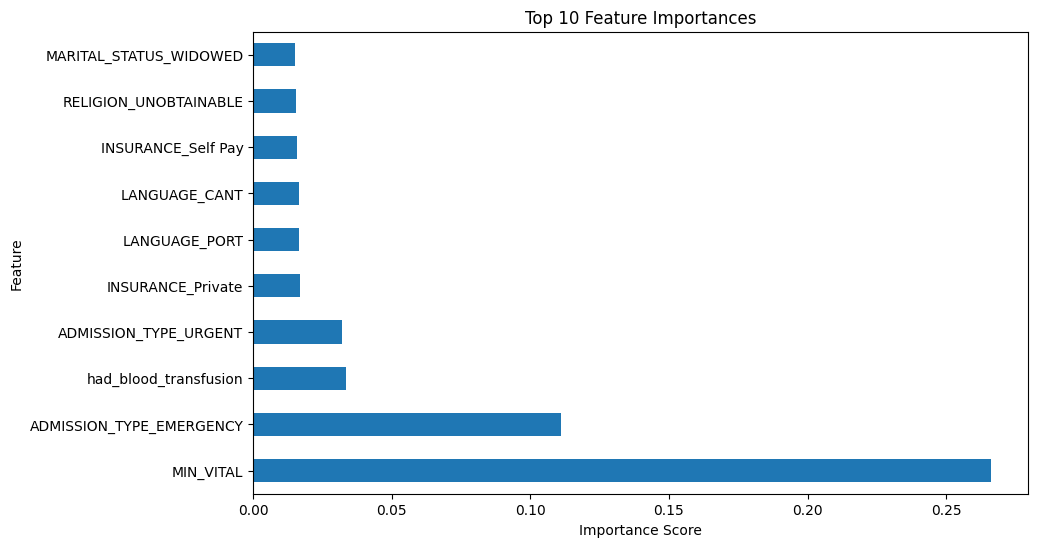

In [ ]:
# Feature importance from Random Forest
feature_importances = rf.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(feature_importances, index=feature_names)

# Plot top 10 features
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


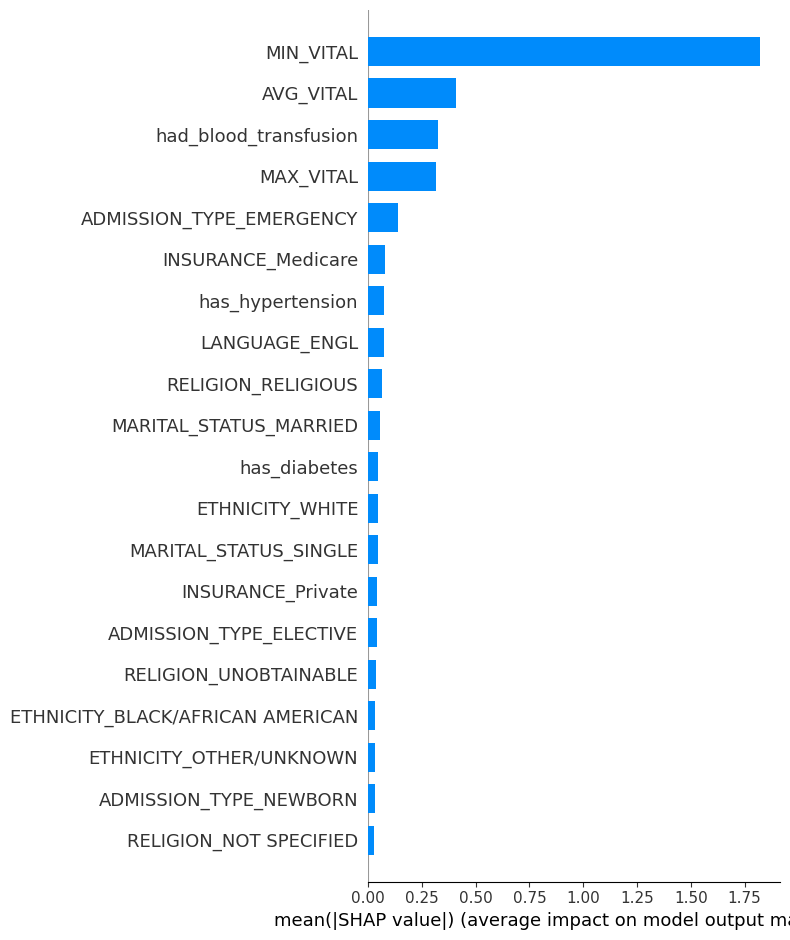

In [ ]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

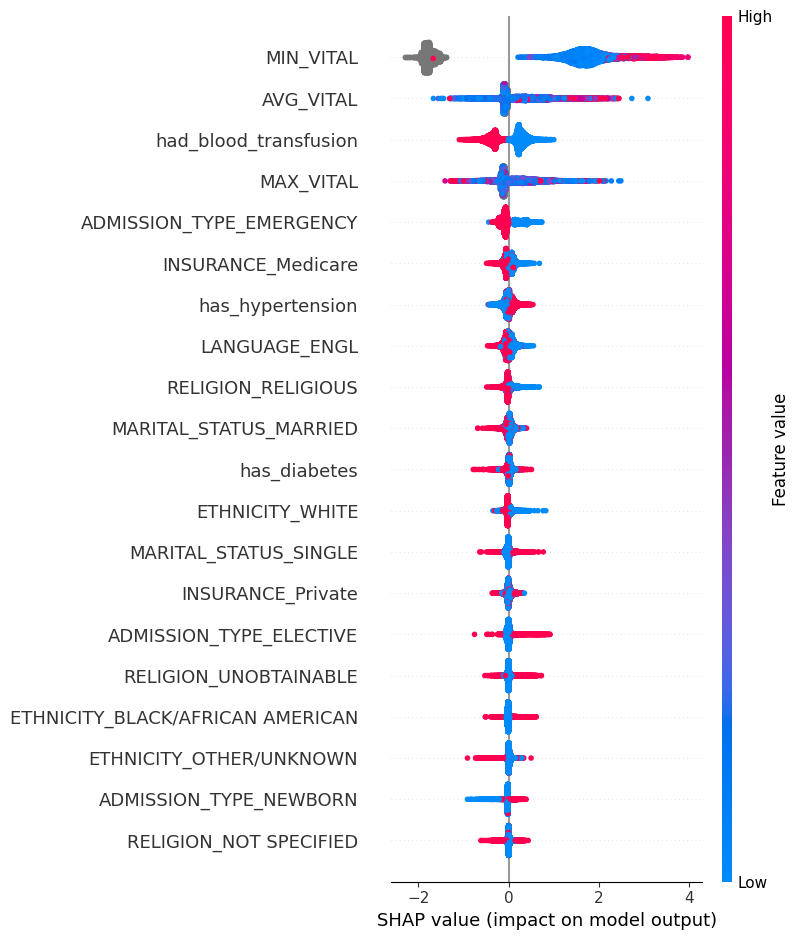

In [ ]:
shap.summary_plot(shap_values, X_test)